In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nipype import Node, Workflow
from nipype.interfaces import fsl
import nipype.pipeline.engine as pe

In [2]:
def plot_slice(fname, z_idx=5):

    # Load the image and collect the data
    # and orientation information
    img = nib.load(fname)
    data = img.get_data()
    aff = img.affine

    # Find the center of the brain matrix
    ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

    # Plot the data
    #vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
    plt.imshow(np.rot90(data[:, :, ctr[2] + z_idx]),
           cmap="gray")
    plt.gca().set_axis_off()

In [3]:
in_file = "/RDSMount/STUDY_DATA/SMART_DATA/001_raw_data_archive/001_nii_data/BL/rsfMRI_nii_4D/SMART001rsfMRI_BL.img"
structural_file = '/RDSMount/STUDY_DATA/SMART_DATA/001_raw_data_archive/001_nii_data/BL/T1_nii/SMART001T1_BL.nii'
standard_brain = "/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz"

In [4]:
motion_correction = pe.MapNode(fsl.MCFLIRT(dof=6), name="motion_correction",iterfield = ['in_file'])

In [5]:
fmri_skullstrip = pe.MapNode(fsl.BET(mask=True,functional=True), name="fmri_skullstrip",iterfield = ['in_file'])

In [6]:
structural_skullstrip = pe.MapNode(fsl.BET(mask=True), name="structural_skullstrip",
                                   iterfield = ['in_file'])

In [7]:
epi_registration = pe.MapNode(fsl.epi.EpiReg(echospacing =0.0007 ),name = "epi_registration",
                              iterfield = ['epi','t1_brain','t1_head'])

In [8]:
highres2standard = pe.MapNode(fsl.FLIRT(reference = standard_brain,cost = 'corratio',dof=12,interp = 'trilinear'),
                             name = 'highres2standard',iterfield = ['in_file'])

In [9]:
standard2highres = pe.MapNode(fsl.ConvertXFM(invert_xfm=True),name = "standard2highres",
                                  iterfield = ['in_file'])

In [10]:
example_func2standard = pe.MapNode(fsl.ConvertXFM(concat_xfm=True),name = "example_func2standard",
                                  iterfield = ['in_file','in_file2'])

/usr/local/lib/python2.7/dist-packages/nipype/interfaces/base.py:431: UserWarning: Input concat_xfm requires inputs: in_file2
  warn(msg)


In [11]:
example_func2standard_full = pe.MapNode(fsl.FLIRT(interp='trilinear',reference = standard_brain,apply_xfm = True,echospacing = 0.0007),
                                name = "example_func2standard_full",
                                  iterfield = ['in_file','in_matrix_file'])

/usr/local/lib/python2.7/dist-packages/nipype/interfaces/base.py:431: UserWarning: Input apply_xfm requires inputs: in_matrix_file
  warn(msg)


In [12]:
wf = Workflow(name="prelim")  # Workflows need names too

In [13]:
""""
wf.connect([(fmri_skullstrip,motion_correction,[('out_file','in_file')]),
            (structural_skullstrip,epi_registration,[('out_file','t1_brain')]),
            (motion_correction,epi_registration,[('out_file','epi')])])
            #(epi_registration,structural_linear_rego,[('out_file','in_file')]),
            #(structural_linear_rego,structural_nonlinear_rego,[('out_file','in_file'),('out_matrix_file','affine_file')])])
        """

'"\nwf.connect([(fmri_skullstrip,motion_correction,[(\'out_file\',\'in_file\')]),\n            (structural_skullstrip,epi_registration,[(\'out_file\',\'t1_brain\')]),\n            (motion_correction,epi_registration,[(\'out_file\',\'epi\')])])\n            #(epi_registration,structural_linear_rego,[(\'out_file\',\'in_file\')]),\n            #(structural_linear_rego,structural_nonlinear_rego,[(\'out_file\',\'in_file\'),(\'out_matrix_file\',\'affine_file\')])])\n        '

In [14]:
wf.connect([(fmri_skullstrip,motion_correction,[('out_file','in_file')]),
            (structural_skullstrip,epi_registration,[('out_file','t1_brain')]),
            (motion_correction,epi_registration,[('out_file','epi')]),
            (epi_registration,example_func2standard,[('epi2str_mat','in_file')]),
            (structural_skullstrip,highres2standard,[('out_file','in_file')]),
            (highres2standard,example_func2standard,[('out_matrix_file','in_file2')]),
            (motion_correction,example_func2standard_full,[('out_file','in_file')]),
            (example_func2standard,example_func2standard_full,[('out_file','in_matrix_file')])])

### Create a set of iterables

161213-12:49:16,957 workflow INFO:
	 Converting dotfile: /media/harrison/Short term/working_dir/prelim/prelim_graph.dot to png format


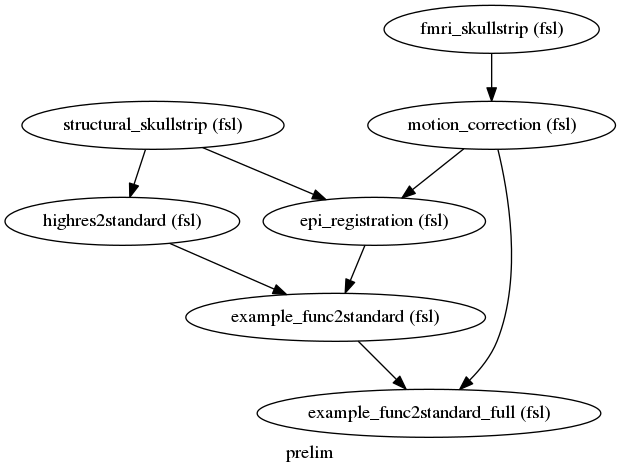

In [15]:
wf.base_dir = "/media/harrison/Short term/working_dir"
wf.write_graph("prelim_graph.dot")
from IPython.display import Image
Image(filename="/media/harrison/Short term/working_dir/prelim/prelim_graph.dot.png")

In [16]:
fmri_path = '/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/rsfMRI_dcm2nii_4D/'
fmri_files = [fmri_path +'SMART001rsfMRI_BL.nii' , fmri_path +'SMART055rsfMRI_BL.nii']

In [17]:
structural_path = '/RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/T1_nii_dcm2nii/'
structural_files = [structural_path + 'SMART001T1_BL.nii' ,structural_path + 'SMART055T1_BL.nii']

In [18]:
fmri_skullstrip.inputs.in_file = fmri_files
structural_skullstrip.inputs.in_file = structural_files
epi_registration.inputs.t1_head = structural_files

In [ ]:
wf.base_dir = "working_dir"
wf.run()

161213-12:49:28,112 workflow INFO:
	 ['check', 'execution', 'logging']
161213-12:49:28,141 workflow INFO:
	 Running serially.
161213-12:49:28,149 workflow INFO:
	 Executing node fmri_skullstrip in dir: /home/harrison/Documents/mri/working_dir/prelim/fmri_skullstrip
161213-12:49:28,184 workflow INFO:
	 Executing node _fmri_skullstrip0 in dir: /home/harrison/Documents/mri/working_dir/prelim/fmri_skullstrip/mapflow/_fmri_skullstrip0
161213-12:49:28,205 workflow INFO:
	 Running: bet /RDSMount/STUDY_DATA/SMART_DATA/HARRISON_WORK/rsfMRI_dcm2nii_4D/SMART001rsfMRI_BL.nii /home/harrison/Documents/mri/working_dir/prelim/fmri_skullstrip/mapflow/_fmri_skullstrip0/SMART001rsfMRI_BL_brain.nii.gz -F -m


In [ ]:
file_show = '/home/harrison/Documents/mri/working_dir/prelim/motion_correction/SMART001rsfMRI_BL_brain_mcf.nii.gz'

In [ ]:
img = nib.load(file_show)
data = img.get_data()
aff = img.affine
print(data.shape)

# Find the center of the brain matrix
ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

# Plot the data
#vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
plt.imshow(np.rot90(data[:, :, ctr[2] + 5,100]),
           cmap="gray")
plt.gca().set_axis_off()

In [ ]:
file_show = '/home/harrison/Documents/mri/working_dir/prelim/fmri_skullstrip/SMART001rsfMRI_BL_brain.nii.gz'

In [ ]:
img = nib.load(file_show)
data = img.get_data()
aff = img.affine

# Find the center of the brain matrix
ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

# Plot the data
#vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
plt.imshow(np.rot90(data[:, :, ctr[2] + 5,100]),
           cmap="gray")
plt.gca().set_axis_off()

In [ ]:
file_show = '/home/harrison/001_reg_no_fmap.feat/filtered_func_data.nii.gz'

In [ ]:
img = nib.load(file_show)
data = img.get_data()
aff = img.affine

In [ ]:
img = nib.load(file_show)
data = img.get_data()
aff = img.affine

# Find the center of the brain matrix
ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

# Plot the data
#vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
plt.imshow(np.rot90(data[:, :, ctr[2] + 5,100]),
           cmap="gray")
plt.gca().set_axis_off()

In [ ]:
file_show = "/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz"

In [ ]:
img = nib.load(file_show)
data = img.get_data()
aff = img.affine

# Find the center of the brain matrix
ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

# Plot the data
#vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
plt.imshow(np.rot90(data[:, :, ctr[2] + 5]),
           cmap="gray")
plt.gca().set_axis_off()

In [ ]:
fsl.epi.EpiReg.help()

In [ ]:
fsl.FLIRT.help()

In [ ]:
fsl.FNIRT.help()